In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import pathlib

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

device = torch.device('cuda:4')

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi']= 125

In [3]:
celeba_data_root = pathlib.Path('/mnt/sdd/MSc_projects/yuchen/vae_experimentation/img_align_celeba')
celeba_img_paths = list(celeba_data_root.glob('*'))
celeba_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64))])
celeba_data = torch.zeros((202599, 3, 64, 64))

In [4]:
for i, path in tqdm(enumerate(celeba_img_paths), total=len(celeba_img_paths)):
    img = plt.imread(path)
    transformed_img = celeba_transform(img)
    celeba_data[i] = transformed_img

  0%|          | 0/202599 [00:00<?, ?it/s]/mnt/sdd/MSc_projects/yuchen/yuchen_env/lib/python3.6/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
100%|██████████| 202599/202599 [57:01<00:00, 59.22it/s]   


In [8]:
#torch.save(celeba_data, '/mnt/sdd/MSc_projects/yuchen/vae_experimentation/celeba_data_processed.pt')

In [9]:
train_data, test_data = train_test_split(celeba_data, test_size=0.2)

In [20]:
class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=32, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),  # B, nc, 64, 64
            nn.Sigmoid()
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)
    
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)
    
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)
            
def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps

model = BetaVAE_H().to(device=device)

/mnt/sdd/MSc_projects/yuchen/yuchen_env/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [192]:
def loss_function(recon, x, mu, logvar, beta=1):
    kl = -0.5 * torch.sum(1 + logvar - torch.exp(logvar) - torch.square(mu))
    kl = kl / len(recon)
    reconloss = torch.sum(torch.square(recon - x)) / len(recon)
    return reconloss + beta*kl

In [202]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [115]:
for batch_idx, batch in enumerate(train_loader):
    test_batch = batch.to(device=device)
    break

In [207]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        batch_gpu = batch.to(device=device)
        recon, mu, logvar = model(batch_gpu)
        loss = loss_function(recon, batch_gpu, mu, logvar, beta=10)
        loss.backward()
        train_loss += loss
        optimizer.step()
    
    print('Epoch: ' + str(epoch) + ' Average train loss: ' + str(train_loss / len(train_data)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_gpu = batch.to(device=device)
            recon, mu, logvar = model(batch_gpu)
            loss = loss_function(recon, batch_gpu, mu, logvar, beta=10)
            test_loss += loss
            
    print('Epoch: ' + str(epoch) + ' Average test loss: ' + str(test_loss / len(test_data)))
    
for epoch in range(1, 100):
    train(epoch)
    test(epoch)

100%|██████████| 2533/2533 [00:45<00:00, 55.53it/s]


Epoch: 1 Average train loss: tensor(6.8450, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 8/2533 [00:00<00:35, 71.92it/s]

Epoch: 1 Average test loss: tensor(6.8738, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.89it/s]


Epoch: 2 Average train loss: tensor(6.8433, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 57.95it/s]

Epoch: 2 Average test loss: tensor(6.8695, device='cuda:4')


100%|██████████| 2533/2533 [00:42<00:00, 59.10it/s]


Epoch: 3 Average train loss: tensor(6.8408, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:46, 54.91it/s]

Epoch: 3 Average test loss: tensor(6.8696, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.98it/s]


Epoch: 4 Average train loss: tensor(6.8392, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:37, 66.81it/s]

Epoch: 4 Average test loss: tensor(6.8626, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.81it/s]


Epoch: 5 Average train loss: tensor(6.8401, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 58.05it/s]

Epoch: 5 Average test loss: tensor(6.8833, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.87it/s]


Epoch: 6 Average train loss: tensor(6.8359, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:41, 61.40it/s]

Epoch: 6 Average test loss: tensor(6.8627, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.31it/s]


Epoch: 7 Average train loss: tensor(6.8351, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:40, 63.13it/s]

Epoch: 7 Average test loss: tensor(6.8681, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.38it/s]


Epoch: 8 Average train loss: tensor(6.8297, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 57.56it/s]

Epoch: 8 Average test loss: tensor(6.8554, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.69it/s]


Epoch: 9 Average train loss: tensor(6.8326, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 57.01it/s]

Epoch: 9 Average test loss: tensor(6.8531, device='cuda:4')


100%|██████████| 2533/2533 [00:46<00:00, 54.93it/s]


Epoch: 10 Average train loss: tensor(6.8283, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:41, 61.02it/s]

Epoch: 10 Average test loss: tensor(6.8564, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.10it/s]


Epoch: 11 Average train loss: tensor(6.8274, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:46, 54.64it/s]

Epoch: 11 Average test loss: tensor(6.8552, device='cuda:4')


100%|██████████| 2533/2533 [00:45<00:00, 55.93it/s]


Epoch: 12 Average train loss: tensor(6.8258, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 5/2533 [00:00<00:52, 48.01it/s]

Epoch: 12 Average test loss: tensor(6.8605, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.34it/s]


Epoch: 13 Average train loss: tensor(6.8247, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:41, 60.61it/s]

Epoch: 13 Average test loss: tensor(6.8517, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.36it/s]


Epoch: 14 Average train loss: tensor(6.8227, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.19it/s]

Epoch: 14 Average test loss: tensor(6.8567, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.13it/s]


Epoch: 15 Average train loss: tensor(6.8221, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.89it/s]

Epoch: 15 Average test loss: tensor(6.8691, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.82it/s]


Epoch: 16 Average train loss: tensor(6.8198, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 58.02it/s]

Epoch: 16 Average test loss: tensor(6.8626, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.62it/s]


Epoch: 17 Average train loss: tensor(6.8204, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 57.02it/s]

Epoch: 17 Average test loss: tensor(6.8464, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.19it/s]


Epoch: 18 Average train loss: tensor(6.8201, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:39, 64.52it/s]

Epoch: 18 Average test loss: tensor(6.8511, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.91it/s]


Epoch: 19 Average train loss: tensor(6.8152, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.63it/s]

Epoch: 19 Average test loss: tensor(6.8537, device='cuda:4')


100%|██████████| 2533/2533 [00:45<00:00, 55.23it/s]


Epoch: 20 Average train loss: tensor(6.8148, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 57.35it/s]

Epoch: 20 Average test loss: tensor(6.8486, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.43it/s]


Epoch: 21 Average train loss: tensor(6.8132, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.63it/s]

Epoch: 21 Average test loss: tensor(6.8444, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.68it/s]


Epoch: 22 Average train loss: tensor(6.8134, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.50it/s]

Epoch: 22 Average test loss: tensor(6.8463, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.24it/s]


Epoch: 23 Average train loss: tensor(6.8127, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:48, 52.42it/s]

Epoch: 23 Average test loss: tensor(6.8591, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.92it/s]


Epoch: 24 Average train loss: tensor(6.8099, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:47, 53.51it/s]

Epoch: 24 Average test loss: tensor(6.8410, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.43it/s]


Epoch: 25 Average train loss: tensor(6.8105, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:45, 55.13it/s]

Epoch: 25 Average test loss: tensor(6.8472, device='cuda:4')


100%|██████████| 2533/2533 [00:46<00:00, 54.02it/s]


Epoch: 26 Average train loss: tensor(6.8058, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 59.68it/s]

Epoch: 26 Average test loss: tensor(6.8407, device='cuda:4')


100%|██████████| 2533/2533 [00:47<00:00, 53.18it/s]


Epoch: 27 Average train loss: tensor(6.8087, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:48, 52.42it/s]

Epoch: 27 Average test loss: tensor(6.8457, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.19it/s]


Epoch: 28 Average train loss: tensor(6.8058, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 5/2533 [00:00<00:50, 49.98it/s]

Epoch: 28 Average test loss: tensor(6.8383, device='cuda:4')


100%|██████████| 2533/2533 [00:45<00:00, 55.32it/s]


Epoch: 29 Average train loss: tensor(6.8029, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:49, 50.90it/s]

Epoch: 29 Average test loss: tensor(6.8376, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.07it/s]


Epoch: 30 Average train loss: tensor(6.8014, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.88it/s]

Epoch: 30 Average test loss: tensor(6.8403, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.72it/s]


Epoch: 31 Average train loss: tensor(6.8024, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 57.05it/s]

Epoch: 31 Average test loss: tensor(6.8482, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.25it/s]


Epoch: 32 Average train loss: tensor(6.8011, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:37, 66.94it/s]

Epoch: 32 Average test loss: tensor(6.8377, device='cuda:4')


100%|██████████| 2533/2533 [00:45<00:00, 55.67it/s]


Epoch: 33 Average train loss: tensor(6.8004, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:48, 52.60it/s]

Epoch: 33 Average test loss: tensor(6.8362, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.77it/s]


Epoch: 34 Average train loss: tensor(6.7986, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 8/2533 [00:00<00:34, 72.33it/s]

Epoch: 34 Average test loss: tensor(6.8361, device='cuda:4')


100%|██████████| 2533/2533 [00:46<00:00, 54.69it/s]


Epoch: 35 Average train loss: tensor(6.8002, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:46, 54.16it/s]

Epoch: 35 Average test loss: tensor(6.8394, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.90it/s]


Epoch: 36 Average train loss: tensor(6.7978, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 59.73it/s]

Epoch: 36 Average test loss: tensor(6.8376, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.42it/s]


Epoch: 37 Average train loss: tensor(6.7972, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 58.26it/s]

Epoch: 37 Average test loss: tensor(6.8372, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.39it/s]


Epoch: 38 Average train loss: tensor(6.7947, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 8/2533 [00:00<00:35, 71.84it/s]

Epoch: 38 Average test loss: tensor(6.8273, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.70it/s]


Epoch: 39 Average train loss: tensor(6.7972, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:49, 51.47it/s]

Epoch: 39 Average test loss: tensor(6.8274, device='cuda:4')


100%|██████████| 2533/2533 [00:47<00:00, 52.90it/s]


Epoch: 40 Average train loss: tensor(6.7952, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 59.78it/s]

Epoch: 40 Average test loss: tensor(6.8310, device='cuda:4')


100%|██████████| 2533/2533 [00:41<00:00, 61.00it/s]


Epoch: 41 Average train loss: tensor(6.7948, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:39, 64.05it/s]

Epoch: 41 Average test loss: tensor(6.8378, device='cuda:4')


100%|██████████| 2533/2533 [00:39<00:00, 64.61it/s]


Epoch: 42 Average train loss: tensor(6.7948, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:47, 53.76it/s]

Epoch: 42 Average test loss: tensor(6.8274, device='cuda:4')


100%|██████████| 2533/2533 [00:39<00:00, 63.91it/s]


Epoch: 43 Average train loss: tensor(6.7922, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 58.69it/s]

Epoch: 43 Average test loss: tensor(6.8358, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.68it/s]


Epoch: 44 Average train loss: tensor(6.7913, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 57.87it/s]

Epoch: 44 Average test loss: tensor(6.8313, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.83it/s]


Epoch: 45 Average train loss: tensor(6.7912, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 58.25it/s]

Epoch: 45 Average test loss: tensor(6.8286, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.10it/s]


Epoch: 46 Average train loss: tensor(6.7892, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:37, 68.04it/s]

Epoch: 46 Average test loss: tensor(6.8315, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.88it/s]


Epoch: 47 Average train loss: tensor(6.7881, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.64it/s]

Epoch: 47 Average test loss: tensor(6.8276, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.89it/s]


Epoch: 48 Average train loss: tensor(6.7897, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:41, 61.21it/s]

Epoch: 48 Average test loss: tensor(6.8247, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.86it/s]


Epoch: 49 Average train loss: tensor(6.7873, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:47, 53.16it/s]

Epoch: 49 Average test loss: tensor(6.8290, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.43it/s]


Epoch: 50 Average train loss: tensor(6.7867, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 57.02it/s]

Epoch: 50 Average test loss: tensor(6.8443, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.53it/s]


Epoch: 51 Average train loss: tensor(6.7869, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:48, 52.43it/s]

Epoch: 51 Average test loss: tensor(6.8333, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.64it/s]


Epoch: 52 Average train loss: tensor(6.7851, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:39, 64.73it/s]

Epoch: 52 Average test loss: tensor(6.8208, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.53it/s]


Epoch: 53 Average train loss: tensor(6.7860, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:46, 54.86it/s]

Epoch: 53 Average test loss: tensor(6.8266, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.22it/s]


Epoch: 54 Average train loss: tensor(6.7858, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 5/2533 [00:00<00:54, 46.33it/s]

Epoch: 54 Average test loss: tensor(6.8261, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.73it/s]


Epoch: 55 Average train loss: tensor(6.7879, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 58.85it/s]

Epoch: 55 Average test loss: tensor(6.8152, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.91it/s]


Epoch: 56 Average train loss: tensor(6.7838, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.26it/s]

Epoch: 56 Average test loss: tensor(6.8281, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.22it/s]


Epoch: 57 Average train loss: tensor(6.7819, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:45, 55.19it/s]

Epoch: 57 Average test loss: tensor(6.8301, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.60it/s]


Epoch: 58 Average train loss: tensor(6.7807, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 5/2533 [00:00<00:51, 49.05it/s]

Epoch: 58 Average test loss: tensor(6.8268, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.87it/s]


Epoch: 59 Average train loss: tensor(6.7818, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:45, 54.97it/s]

Epoch: 59 Average test loss: tensor(6.8218, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.45it/s]


Epoch: 60 Average train loss: tensor(6.7835, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.21it/s]

Epoch: 60 Average test loss: tensor(6.8229, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.45it/s]


Epoch: 61 Average train loss: tensor(6.7782, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 58.46it/s]

Epoch: 61 Average test loss: tensor(6.8204, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.98it/s]


Epoch: 62 Average train loss: tensor(6.7797, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 59.13it/s]

Epoch: 62 Average test loss: tensor(6.8218, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.66it/s]


Epoch: 63 Average train loss: tensor(6.7786, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:39, 64.74it/s]

Epoch: 63 Average test loss: tensor(6.8219, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.85it/s]


Epoch: 64 Average train loss: tensor(6.7776, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:46, 54.90it/s]

Epoch: 64 Average test loss: tensor(6.8180, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.86it/s]


Epoch: 65 Average train loss: tensor(6.7761, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:49, 51.15it/s]

Epoch: 65 Average test loss: tensor(6.8292, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.54it/s]


Epoch: 66 Average train loss: tensor(6.7774, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 8/2533 [00:00<00:32, 78.22it/s]

Epoch: 66 Average test loss: tensor(6.8199, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.98it/s]


Epoch: 67 Average train loss: tensor(6.7779, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 58.67it/s]

Epoch: 67 Average test loss: tensor(6.8124, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.62it/s]


Epoch: 68 Average train loss: tensor(6.7758, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:47, 52.93it/s]

Epoch: 68 Average test loss: tensor(6.8160, device='cuda:4')


100%|██████████| 2533/2533 [00:45<00:00, 55.30it/s]


Epoch: 69 Average train loss: tensor(6.7734, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:39, 63.23it/s]

Epoch: 69 Average test loss: tensor(6.8258, device='cuda:4')


100%|██████████| 2533/2533 [00:40<00:00, 62.76it/s]


Epoch: 70 Average train loss: tensor(6.7748, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:41, 61.33it/s]

Epoch: 70 Average test loss: tensor(6.8136, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.74it/s]


Epoch: 71 Average train loss: tensor(6.7743, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.48it/s]

Epoch: 71 Average test loss: tensor(6.8177, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.71it/s]


Epoch: 72 Average train loss: tensor(6.7748, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.19it/s]

Epoch: 72 Average test loss: tensor(6.8236, device='cuda:4')


100%|██████████| 2533/2533 [00:40<00:00, 63.25it/s]


Epoch: 73 Average train loss: tensor(6.7725, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:39, 64.23it/s]

Epoch: 73 Average test loss: tensor(6.8234, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.16it/s]


Epoch: 74 Average train loss: tensor(6.7744, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:49, 51.33it/s]

Epoch: 74 Average test loss: tensor(6.8141, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.76it/s]


Epoch: 75 Average train loss: tensor(6.7730, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.21it/s]

Epoch: 75 Average test loss: tensor(6.8330, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.17it/s]


Epoch: 76 Average train loss: tensor(6.7730, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 5/2533 [00:00<00:50, 49.62it/s]

Epoch: 76 Average test loss: tensor(6.8127, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.56it/s]


Epoch: 77 Average train loss: tensor(6.7727, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 59.18it/s]

Epoch: 77 Average test loss: tensor(6.8161, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.58it/s]


Epoch: 78 Average train loss: tensor(6.7713, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 57.85it/s]

Epoch: 78 Average test loss: tensor(6.8103, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 56.81it/s]


Epoch: 79 Average train loss: tensor(6.7694, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:46, 53.85it/s]

Epoch: 79 Average test loss: tensor(6.8147, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.11it/s]


Epoch: 80 Average train loss: tensor(6.7712, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.54it/s]

Epoch: 80 Average test loss: tensor(6.8105, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.21it/s]


Epoch: 81 Average train loss: tensor(6.7712, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:45, 55.00it/s]

Epoch: 81 Average test loss: tensor(6.8171, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.23it/s]


Epoch: 82 Average train loss: tensor(6.7710, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 59.77it/s]

Epoch: 82 Average test loss: tensor(6.8088, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.64it/s]


Epoch: 83 Average train loss: tensor(6.7707, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:45, 55.34it/s]

Epoch: 83 Average test loss: tensor(6.8158, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.08it/s]


Epoch: 84 Average train loss: tensor(6.7676, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.87it/s]

Epoch: 84 Average test loss: tensor(6.8029, device='cuda:4')


100%|██████████| 2533/2533 [00:45<00:00, 55.31it/s]


Epoch: 85 Average train loss: tensor(6.7706, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 57.06it/s]

Epoch: 85 Average test loss: tensor(6.8294, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.30it/s]


Epoch: 86 Average train loss: tensor(6.7681, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:46, 54.46it/s]

Epoch: 86 Average test loss: tensor(6.8067, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.03it/s]


Epoch: 87 Average train loss: tensor(6.7667, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:48, 51.58it/s]

Epoch: 87 Average test loss: tensor(6.8116, device='cuda:4')


100%|██████████| 2533/2533 [00:46<00:00, 54.32it/s]


Epoch: 88 Average train loss: tensor(6.7654, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:45, 55.98it/s]

Epoch: 88 Average test loss: tensor(6.8104, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.37it/s]


Epoch: 89 Average train loss: tensor(6.7670, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:49, 51.24it/s]

Epoch: 89 Average test loss: tensor(6.8141, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.58it/s]


Epoch: 90 Average train loss: tensor(6.7653, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:41, 61.27it/s]

Epoch: 90 Average test loss: tensor(6.8116, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.60it/s]


Epoch: 91 Average train loss: tensor(6.7667, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:41, 60.49it/s]

Epoch: 91 Average test loss: tensor(6.8043, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.75it/s]


Epoch: 92 Average train loss: tensor(6.7644, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:42, 59.16it/s]

Epoch: 92 Average test loss: tensor(6.8109, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.04it/s]


Epoch: 93 Average train loss: tensor(6.7657, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 7/2533 [00:00<00:39, 63.62it/s]

Epoch: 93 Average test loss: tensor(6.8082, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.01it/s]


Epoch: 94 Average train loss: tensor(6.7631, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:48, 52.00it/s]

Epoch: 94 Average test loss: tensor(6.8098, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.64it/s]


Epoch: 95 Average train loss: tensor(6.7648, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 57.84it/s]

Epoch: 95 Average test loss: tensor(6.8151, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 58.24it/s]


Epoch: 96 Average train loss: tensor(6.7643, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:44, 56.48it/s]

Epoch: 96 Average test loss: tensor(6.8023, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.39it/s]


Epoch: 97 Average train loss: tensor(6.7624, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:43, 57.61it/s]

Epoch: 97 Average test loss: tensor(6.8028, device='cuda:4')


100%|██████████| 2533/2533 [00:44<00:00, 57.24it/s]


Epoch: 98 Average train loss: tensor(6.7645, device='cuda:4', grad_fn=<DivBackward0>)


  0%|          | 6/2533 [00:00<00:48, 52.31it/s]

Epoch: 98 Average test loss: tensor(6.8074, device='cuda:4')


100%|██████████| 2533/2533 [00:43<00:00, 57.91it/s]


Epoch: 99 Average train loss: tensor(6.7623, device='cuda:4', grad_fn=<DivBackward0>)
Epoch: 99 Average test loss: tensor(6.8104, device='cuda:4')


In [208]:
torch.save(model.state_dict(), '/mnt/sdd/MSc_projects/yuchen/vae_experimentation/trained_models/VAE-celeba-beta-250-statedict-epoch150.pt')

In [35]:
model = BetaVAE_H()
model.load_state_dict(torch.load('/mnt/sdd/MSc_projects/yuchen/vae_experimentation/trained_models/VAE-celeba-beta-10-statedict-epoch150.pt'))
model.eval()

/mnt/sdd/MSc_projects/yuchen/yuchen_env/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


BetaVAE_H(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): View()
    (11): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): View()
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(64, 32, kernel_siz

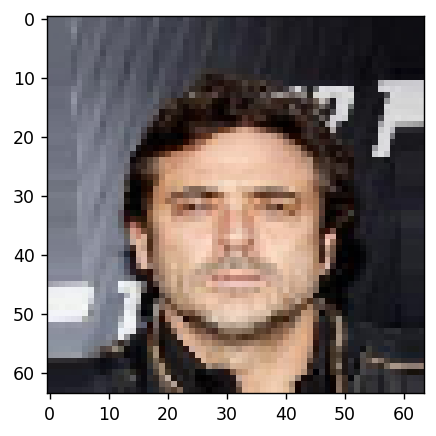

In [13]:
test_img = test_data[60].unsqueeze(0)
plt.imshow(test_img[0].permute(1, 2, 0))

In [14]:
test_img.shape

torch.Size([1, 3, 64, 64])

In [15]:
recon, mu, logvar = model(test_img.to(device=device))

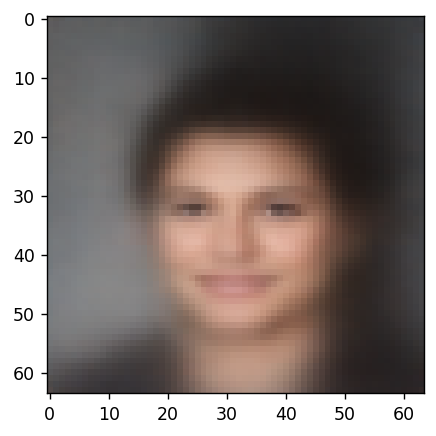

In [16]:
plt.imshow(recon[0].cpu().detach().permute(1, 2, 0))

In [17]:
rand = np.random.randint(0, len(test_data))
seed_img = test_data[rand].unsqueeze(0)
_, mu, logvar = model(seed_img.to(device=device))
seed_z = torch.normal(mu, torch.sqrt(torch.exp(logvar))).detach().cpu()[0]

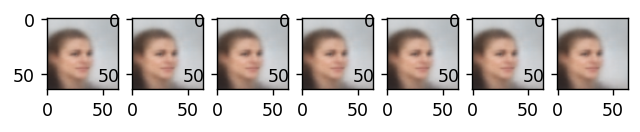

In [18]:
fig, axs = plt.subplots(1, 7)
for i, x in enumerate(np.linspace(-3, 3, 7)):
    traversal_z = torch.clone(seed_z).to(device=device)
    traversal_img = model._decode(traversal_z)
    axs[i].imshow(traversal_img[0].cpu().detach().permute(1, 2, 0))

In [22]:
plt.ioff()
nrow, ncol = 32, 7
fig = plt.figure(figsize=(ncol+1, nrow+1))
gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for latent_idx in tqdm(range(32)):
    rand = np.random.randint(0, len(test_data))
    seed_img = test_data[rand].unsqueeze(0)
    _, mu, logvar = model(seed_img.to(device=device))
    seed_z = torch.normal(mu, torch.sqrt(torch.exp(logvar))).detach().cpu()[0]
    
    for i, x in enumerate(np.linspace(-20, 20, 7)):
        traversal_z = torch.clone(seed_z).to(device=device)
        traversal_z[latent_idx] = x
        traversal_img = model._decode(traversal_z)
        ax = plt.subplot(gs[latent_idx, i])
        ax.imshow(traversal_img[0].cpu().detach().permute(1, 2, 0))
        ax.axis('off')

plt.savefig('/mnt/sdd/MSc_projects/yuchen/vae_experimentation/figs/temp_test_traversal_2.png', bbox_inches = 'tight')
plt.close(fig)

100%|██████████| 32/32 [00:04<00:00,  6.43it/s]


In [38]:
# Non GPU version
plt.ioff()
nrow, ncol = 32, 7
fig = plt.figure(figsize=(ncol+1, nrow+1))
gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for latent_idx in tqdm(range(32)):
    rand = np.random.randint(0, len(test_data))
    seed_img = test_data[rand].unsqueeze(0)
    _, mu, logvar = model(seed_img)
    seed_z = torch.normal(mu, torch.sqrt(torch.exp(logvar))).detach()[0]
    
    for i, x in enumerate(np.linspace(-3, 3, 7)):
        traversal_z = torch.clone(seed_z)
        traversal_z[latent_idx] = x
        traversal_img = model._decode(traversal_z)
        ax = plt.subplot(gs[latent_idx, i])
        ax.imshow(traversal_img[0].detach().permute(1, 2, 0))
        ax.axis('off')

plt.savefig('/mnt/sdd/MSc_projects/yuchen/vae_experimentation/figs/temp_test_traversal_4.png', bbox_inches = 'tight')
plt.close(fig)

100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


In [42]:
plt.ioff()
target_latent = 4
nrow, ncol = 5, 7
fig = plt.figure(figsize=(ncol+1, nrow+1))
gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for idx in range(5):
    rand = np.random.randint(0, len(test_data))
    seed_img = test_data[rand].unsqueeze(0)
    _, mu, logvar = model(seed_img)
    seed_z = torch.normal(mu, torch.sqrt(torch.exp(logvar))).detach()[0]
    
    for i, x in enumerate(np.linspace(-3, 3, 7)):
        traversal_z = torch.clone(seed_z)
        traversal_z[target_latent] = x
        traversal_img = model._decode(traversal_z)
        ax = plt.subplot(gs[idx, i])
        ax.imshow(traversal_img[0].detach().permute(1, 2, 0))
        ax.axis('off')

plt.savefig('/mnt/sdd/MSc_projects/yuchen/vae_experimentation/figs/beta-10-azimuth.png', dpi=300, bbox_inches = 'tight')
plt.close(fig)

In [186]:
print('test')

test


In [176]:
traversal_img.shape

torch.Size([1, 3, 64, 64])